<a href="https://colab.research.google.com/github/xspronken/bigdataW1/blob/master/LightCurves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
!pip install astroquery

In [0]:
import numpy as np
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as p
from IPython.display import display, HTML

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

%matplotlib inline

In [0]:
planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

#input a known id of object you want to study here (TIC, TOI, Planet or star name; ex: "CoRoT-1 b", "TIC 186812530", "TOI 101.01"  )
object_id = "CoRoT-1 b"

url = planeturl + "/identifiers/"

myparams = {"name":object_id}

r = requests.get(url = url, params = myparams, headers = header)

#fetches ID, coordinates and TCE associated with the object of the object
object_names = r.json()
ticid = object_names['tessID']
tce = object_names['tessTCE']
ra = object_names['ra']
dec = object_names['dec']
coord = SkyCoord(ra, dec, unit = "deg")

#fetches all the ffi frames available for this object
cutout_hdu = Tesscut.get_cutouts(coord, 10)


Number of sectors searches available: 1

Sector: s0006-s0006
Object Radius: 17.582953


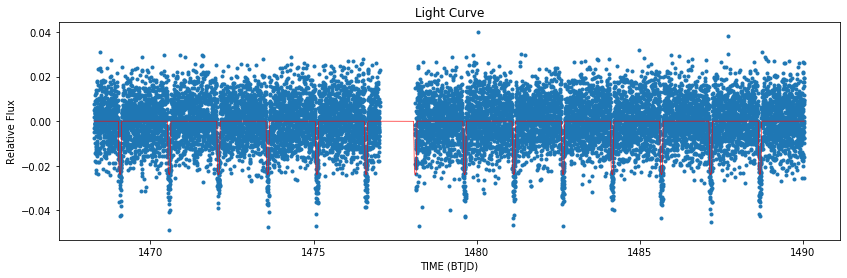

First FFI frame of sector: 6
Cutout_index: 0


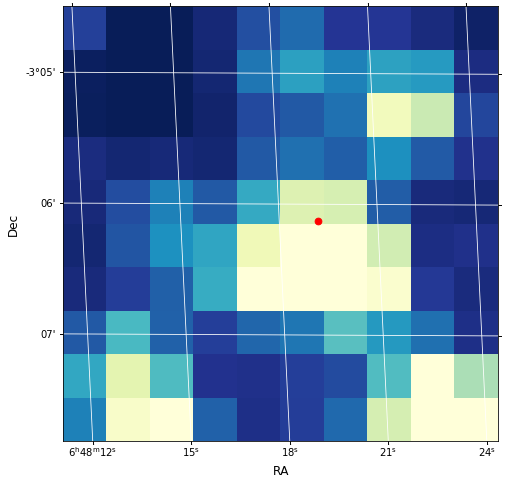

In [274]:
sector_light_curves (ticid)
sector_ffi_1st_frame (cutout_hdu)


In [281]:
sector = 6 #choose which sector's ffi you wish to animate

cutout_index = sector_to_cutout_index(cutout_hdu, sector) 

start = find_frame(cutout_index, 1470) #converts BTJD dates to the corresponding ffi frame
end = find_frame(cutout_index, 1471)
print(start)
print(end)
make_animation(cutout_hdu[cutout_index], start ,end)

82
130


In [0]:
def sector_light_curves (ticid):
  #fetches all the sectors in which we can find the object
  url = dvurl + str(ticid) + '/tces/'
  myparams = {"tce" : tce}

  r = requests.get(url = url, params = myparams, headers = header)
  sectorInfo = r.json()
  sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
  print ("Number of sectors searches available: %i" % len(sectors))
  
# Loop that prints the light curves for each sector
  if(len(sectors) != 0 ):
    for z in range (len(sectors)):
      url = dvurl + str(ticid) + '/info/'
      myparams = {"tce" : tce,
                  "sector" : sectors[z]}

      r = requests.get(url = url, params = myparams, headers = header)
      tceInfo = r.json()
      tceInfo.keys()
      tceInfo['DV Data Header'].keys()
      
      print ("\nSector: " + sectors[z])
      print("Object Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

      
      # Get The data for the light curve
      url = dvurl + str(ticid) + '/table/'
      myparams = {"tce" : tce,
                  "sector" : sectors[z]}
      r = requests.get(url = url, params = myparams, headers = header)
      tce_data = r.json()
      data = p.DataFrame.from_dict(tce_data['data'])
      detrend = data['LC_DETREND']
      model = data['MODEL_INIT']
      time = data['TIME']
      
      #Plot the light curve
      plt.figure(figsize=(14,4))
      plt.plot(time,detrend,'.',lw=0.4)
      plt.plot(time,model,'r-',lw=0.6)
      plt.xlabel('TIME (BTJD)')
      plt.ylabel('Relative Flux')
      plt.title("Light Curve")
      plt.show()
      
      
      #Fetch the bokeh folded light curve
      url = dvurl + str(ticid) + '/phaseplot/'
      myparams = {"tce" : tce,
                  "sector" : sectors[z]}

      r = requests.get(url = url, params = myparams, headers = header)

      display(HTML(str(r.content.decode('utf-8'))))
    
  return None 

In [0]:
def sector_ffi_1st_frame (cutout_hdu):
  for i in range(len(cutout_hdu)):
    hdu = cutout_hdu[i]
    print ("First FFI frame of sector: %i" %hdu[0].header['sector'])
    print ("Cutout_index: %i" %i)
    image = hdu[1].data['FLUX'][1]
    wcs = WCS(hdu[2].header)

    fig = plt.figure(figsize = (8, 8))
    fig.add_subplot(111, projection = wcs)
    
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

    plt.xlabel('RA', fontsize = 12)
    plt.ylabel('Dec', fontsize = 12)


    starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
    plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')
    plt.show()
  return None

In [0]:
def sector_to_cutout_index(cutout_hdu, sector):
  for i in range(len(cutout_hdu)):
    hdu = cutout_hdu[i]
    if (hdu[0].header['sector'] == sector):
      break
  return i

In [0]:
def find_frame(index, btjd):
    """
    Given a time as a Barycentric TESS Julian Date (BTJD) timestamp, return the closest index in a table
    that is assumed to have a TIME column that is also in BTJD"""
    
    return (np.abs(cutout_hdu[index][1].data['TIME'] - btjd)).argmin()

In [0]:
def make_animation(hdu, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    data_array = hdu[1].data['FLUX']
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Frame #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani